In [2]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE # wrapper method pour choisir les features
from sklearn.preprocessing import OneHotEncoder
import pickle
import re 
import pandas as pd
import shap
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve, precision_recall_curve 
from math import sqrt 
#from mlflow.models.signature import infer_signature
#Export new_df_test => sera utilisé pour la prédiction du modele avec fastapi
import requests
import io
import base64
from bokeh.plotting import figure, output_notebook, show
import evidently
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metric_preset import TargetDriftPreset
from evidently.metric_preset import ClassificationPreset
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import seaborn as sns
from imblearn.over_sampling import ADASYN
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
from sklearn.metrics import classification_report


C:\Users\utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HALVING GRID SEARCH + rapide sinon min 5h
https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155
https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

try:
    import evidently
except:
    !pip install git+https://github.com/evidentlyai/evidently.git

Importation des fichiers

In [3]:
df_train= pd.read_csv("../../datasets/application_train.csv")
df_test = pd.read_csv("../../datasets/application_test.csv")
print(df_train.shape,df_test.shape)
#df_test.shape #confirmation de la suppression des 4 lignes

(307511, 122) (48744, 121)


In [4]:
df_train['TARGET'].value_counts(dropna=False)

0    282686
1     24825
Name: TARGET, dtype: int64

Data leakage 

In [4]:
df_train.corr()['TARGET'].sort_values(ascending=False)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
                                 ...   
FLOORSMAX_AVG                 -0.044003
DAYS_EMPLOYED                 -0.044932
EXT_SOURCE_1                  -0.155317
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_3                  -0.178919
Name: TARGET, Length: 106, dtype: float64

Nous avons a priori rien de très corrélé donc pas de data leakage avec les données de base

Remplacement des valeurs manquantes

In [5]:
for col_na in df_train.isna().sum()[df_train.isna().sum() > 0 ].index: 
    print(col_na,df_train[col_na].dtype)
    if df_train[col_na].dtype =='object':
        print(col_na)
        df_train[col_na] = df_train[col_na].fillna(df_train[col_na].mode().values[0]) # var categ val mqte => mot le plus fréquent
    else :
        df_train[col_na] = df_train[col_na].fillna(df_train[col_na].median()) # val mqtes => mediane
df_train.isna().sum().sum(), df_train.shape

AMT_ANNUITY float64
AMT_GOODS_PRICE float64
NAME_TYPE_SUITE object
NAME_TYPE_SUITE
OWN_CAR_AGE float64
OCCUPATION_TYPE object
OCCUPATION_TYPE
CNT_FAM_MEMBERS float64
EXT_SOURCE_1 float64
EXT_SOURCE_2 float64
EXT_SOURCE_3 float64
APARTMENTS_AVG float64
BASEMENTAREA_AVG float64
YEARS_BEGINEXPLUATATION_AVG float64
YEARS_BUILD_AVG float64
COMMONAREA_AVG float64
ELEVATORS_AVG float64
ENTRANCES_AVG float64
FLOORSMAX_AVG float64
FLOORSMIN_AVG float64
LANDAREA_AVG float64
LIVINGAPARTMENTS_AVG float64
LIVINGAREA_AVG float64
NONLIVINGAPARTMENTS_AVG float64
NONLIVINGAREA_AVG float64
APARTMENTS_MODE float64
BASEMENTAREA_MODE float64
YEARS_BEGINEXPLUATATION_MODE float64
YEARS_BUILD_MODE float64
COMMONAREA_MODE float64
ELEVATORS_MODE float64
ENTRANCES_MODE float64
FLOORSMAX_MODE float64
FLOORSMIN_MODE float64
LANDAREA_MODE float64
LIVINGAPARTMENTS_MODE float64
LIVINGAREA_MODE float64
NONLIVINGAPARTMENTS_MODE float64
NONLIVINGAREA_MODE float64
APARTMENTS_MEDI float64
BASEMENTAREA_MEDI float64
YEARS_B

(0, (307511, 122))

Separation du jdd

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df_train.drop(['TARGET'], axis =1),
                                                 df_train['TARGET'],
                                                test_size=0.3,
                                                random_state=42)

One hot encoder sélection des colonnes catégorielles 

In [7]:
# et des valeurs qu'on souhaite retr
ar = X_train.select_dtypes('object').columns #nom des colonnes sous format objets
ar_val = []
for index,ar_values in enumerate(ar) :
    ar_val.append([i for i in (X_train[ar_values].value_counts().index.values)]) # avoir les valeurs de chaque colonne catégorielles dans une liste => une liste de valeurs/col
ar_val[:5]

[['Cash loans', 'Revolving loans'],
 ['F', 'M', 'XNA'],
 ['N', 'Y'],
 ['Y', 'N'],
 ['Unaccompanied',
  'Family',
  'Spouse, partner',
  'Children',
  'Other_B',
  'Other_A',
  'Group of people']]

# Pipeline One Hot Encoder +  Scaler + Over Sampling

Pipeline

In [7]:
pipeline_o = Pipeline(steps=[
                             ('categ_scaler',ColumnTransformer([('one-hot-encoder',
                                               OneHotEncoder(
                                                        handle_unknown="ignore",
                                                        categories=ar_val),
                                                        ar.values)],
                                                        remainder=StandardScaler(with_mean=True),
                                                        verbose=True)
                              )
                             ])
X_train_pipe = pipeline_o.fit_transform(X_train)


[ColumnTransformer]  (1 of 2) Processing one-hot-encoder, total=   4.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   3.1s


Mieux vaut exporter avec un modele plus simple

# export pipeline de transformation
pickle_out = open("pipel_5.pkl", "wb")
pickle.dump(pipeline_o pickle_out)
pickle_out.close()

Oversampling

In [8]:
#oversampling apres parce que sinon variables catégorielles et ne fonctionne pas
over = ADASYN(random_state=42)
X_train_over,y_train_over = over.fit_resample(X_train_pipe,y_train)
df_train.shape[0],X_train_over.shape[0],np.bincount(y_train_over)

(307511, 394743, array([197845, 196898], dtype=int64))

Modélisation

In [10]:
params = [
    {'clf':[AdaBoostClassifier(random_state=42)],
     'clf__n_estimators' :[200,500],
     'clf__learning_rate' :[0.2,0.4]},
    
    {'clf':[lgb.LGBMClassifier(random_state=42)],
     'clf__n_estimators' :[200,500],
     'clf__learning_rate' :[0.2,0.4]}
]
pipeline_clf = Pipeline([('clf', AdaBoostClassifier(random_state=42))]) # a voir si possibilité d'inclure à l'autre pipeline

In [20]:
# passer n_jobs de 1 à 2 egale pas d'erreur ?
scoring = {"AUC": "roc_auc", "Recall": "recall"} # ne fonctionne pas  halving grid search ne prends qu'un parametre
search = HalvingGridSearchCV(estimator=pipeline_clf,
                             param_grid=params,
                             n_jobs=1,
                             scoring="recall",
                             min_resources=65000,
                             verbose=10,
                             factor=2)
# 21 min pour un parametre dans le gridsearch et 4 parametres dans ridgeclassifier
search.fit(X_train_over, y_train_over)
# Résultats du meilleur modele
search.cv_results_

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 65000
max_resources_: 394743
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 65000
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START clf=AdaBoostClassifier(random_state=42), clf__learning_rate=0.2, clf__n_estimators=200
[CV 1/5; 1/8] END clf=AdaBoostClassifier(random_state=42), clf__learning_rate=0.2, clf__n_estimators=200;, score=(train=0.955, test=0.537) total time= 9.5min
[CV 2/5; 1/8] START clf=AdaBoostClassifier(random_state=42), clf__learning_rate=0.2, clf__n_estimators=200
[CV 2/5; 1/8] END clf=AdaBoostClassifier(random_state=42), clf__learning_rate=0.2, clf__n_estimators=200;, score=(train=0.865, test=0.960) total time= 9.7min
[CV 3/5; 1/8] START clf=AdaBoostClassifier(random_state=42), clf__learning_rate=0.2, clf__n_estimators=200
[CV 3/5; 1/8] END clf=AdaBoostClassifier(random_state=42), clf__learning_rate=0.2, clf__n_estimato

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2]),
 'n_resources': array([ 65000,  65000,  65000,  65000,  65000,  65000,  65000,  65000,
        130000, 130000, 130000, 130000, 260000, 260000]),
 'mean_fit_time': array([ 539.89271708, 1217.11652956,  548.86286306, 1107.10225859,
          10.97019534,   15.26399765,    9.12760077,   15.41099963,
          15.53143563,   24.58779783,   15.57139544,   22.72539682,
          39.88659015,   38.62099829]),
 'std_fit_time': array([34.78689259, 68.7976699 , 35.74256274, 23.37911174,  2.75923699,
         3.2646183 ,  2.64338943,  3.6279281 ,  0.59231257,  3.33322243,
         1.47356355,  2.48091311,  3.9122237 ,  3.3699268 ]),
 'mean_score_time': array([ 9.80060906, 23.12719727, 10.71540365, 22.70057549,  0.10839982,
         0.18400025,  0.12080197,  0.17720003,  0.17360106,  0.38480239,
         0.33920293,  0.32759972,  0.75180225,  0.61620312]),
 'std_score_time': array([0.26290836, 2.14348055, 1.82828343, 0.14532177, 0.0281601

In [21]:
search.best_score_

0.9108537701182632

In [24]:
search.best_estimator_

Pipeline(steps=[('clf',
                 LGBMClassifier(learning_rate=0.4, n_estimators=500,
                                random_state=42))])

# Test overfitting du modele

In [71]:
pred = search.best_estimator_.predict(pipeline_o['categ_scaler'].transform(X_test))
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)

0.5237123399315513

Modele aussi mauvais que si on jouait à pile ou face

# Mlflow tracking : suivi des parametres et du meilleur modele

In [25]:
#mlflow.get_tracking_uri()
mlflow.set_tracking_uri('http://127.0.0.1:5000') # changé de 5000

In [37]:
mlflow.set_experiment("classifier_ + Halving_Gridsearch") #Set the given experiment as the active experiment. The experiment must either be specified by name via experiment_name 
for i in range(len(search.cv_results_['params'])): # search remplace log_reg
    run_index = i
    cv_results = search.cv_results_
    with mlflow.start_run(run_name=str(run_index)) as run:  
            mlflow.log_param("folds", search.cv)
            print("Logging parameters")
            for dict_ in search.param_grid : #ajouté parce que deux dictionnaires au lieu d'un seul
                params = list(dict_.keys())
            #params = list(search.param_grid.keys())
                for param in params:
                    mlflow.log_param(param, cv_results["param_%s" % param][run_index])
                print("Logging metrics")
                for score_name in [score for score in cv_results if "mean_test" in score]:
                    mlflow.log_metric(score_name, cv_results[score_name][run_index])
                    mlflow.log_metric(score_name.replace("mean","std"), cv_results[score_name.replace("mean","std")][run_index])
                print("Logging model")        
                mlflow.sklearn.log_model(search.best_estimator_, 'hgs')

Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model
Log

selectionner le meilleur modele

In [79]:
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
runs = mlflow.search_runs(experiment_ids=all_experiments,
                          order_by=['metrics.mean_test_score DESC'],
                          max_results=1)
runs

run_id       experiment_id    status  \
0  e4eae7532d054de7b3343234582f1a3f  305121319602746505  FINISHED   

                                        artifact_uri  \
0  mlflow-artifacts:/305121319602746505/e4eae7532...   

                        start_time                         end_time  \
0 2023-03-17 07:50:50.027000+00:00 2023-03-17 07:51:22.407000+00:00   

   metrics.std_test_score  metrics.mean_test_score params.clf__n_estimators  \
0                 0.17615                 0.911137                      500   

                                          params.clf  \
0  LGBMClassifier(learning_rate=0.4, n_estimators...   

  params.clf__learning_rate params.folds tags.mlflow.user tags.mlflow.runName  \
0                       0.4            5      utilisateur                  11   

                       tags.mlflow.log-model.history  \
0  [{"run_id": "e4eae7532d054de7b3343234582f1a3f"...   

                             tags.mlflow.source.name tags.mlflow.source.type  
0  C:\Users\utilisateur\AppData\Local\Packages\Py...                   LOCAL

Charger le model à partir de mlflow à finir

In [87]:
import mlflow.pyfunc

model_name = "sk-learn-random-forest-reg-model"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}"

Export du meilleur modele a supprimer apres

In [95]:
pickle_out = open("model_ada.pkl","wb") # ada et lgbm
pickle.dump(search.best_estimator_,pickle_out)
pickle_out.close()

In [91]:
pi_mo = Pipeline(steps=[('categ_scaler', ColumnTransformer([('one-hot-encoder',
                                                            OneHotEncoder(
                                                                handle_unknown="ignore",
                                                                categories=ar_val),
                                                             ar.values)],
                                                           remainder=StandardScaler(
                                                               with_mean=True),
                                                           verbose=True)),
                         ('modelisation', search.best_estimator_)
                         ])


NameError: name 'search' is not defined

Export pipeline + modele

In [124]:
pipe_exp = open('pipeline_transfo_model.pkl','wb')
pickle.dump(pi_mo,pipe_exp)
pipe_exp.close()

Import du modele qu'on a exporté pour tester

pickle_in = open("model.pkl","rb") #notre classifier_test importé v2 avec model pipel_4 plus de parametre
classifier_test=pickle.load(pickle_in) #chargé dans une variable
classifier_test.predict(pd.DataFrame(X_test.iloc[0,:]).transpose())#X_test.loc[0,:] pd.DataFrame(X_test.iloc[0,:]).transpose()

# Scoring

Définition du seuil  pour réaliser le scoring

In [103]:
class_rep = classification_report(y_test, pi_mo.predict(X_test))
print(class_rep)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     84841
           1       0.23      0.07      0.10      7413

    accuracy                           0.91     92254
   macro avg       0.58      0.52      0.53     92254
weighted avg       0.87      0.91      0.88     92254



Recall très faible, a pallier autrement qu'un adasyn ? ou autre parametre a modifier dans adasyn oversampling 

Fonction côut expert métier

In [112]:
# a gauche 0 a droite 1 
proba_prediction = pi_mo.predict_proba(X_test) # sous format pourcentage de chance 0 et pourcenatge de chance 1 

 vu que proba prediction donne les proba pour   0 et 1 


 si je prends proba de 1 pour dire si oui ou non 0 (aucun probleme de remboursmenet )

 ex 0: 0,19 ; 1:0.81 , 0.81 >0.13 => probleme de remboursement donc 1


 donc on ne prendra que y en choix de décision, c'est lui qui nous intéresse le plus

In [118]:
predict_proba_values = pi_mo.predict_proba(X_test)#classifier_test.decision_function(X_test)
def my_score(y_pred,y_true):
        score = np.array([])
        fp = (y_pred &~y_true).sum() # parmis toutes les prédictions positives, quelles sont les négatives == faux positif
        fn = (~y_pred &y_true).sum() # parmis toutes les prédictions négatives, quelles sont celles qui sont positives == faux négatif
        score = 1*fp +10*fn
        return score

list_threshold = []

def best_score(predict_proba_values=pi_mo.predict_proba(X_test)[:,1]): #proba pour  que la prédiction soit égale à 1
    ar_score = np.array([])
    for idx, threshold in enumerate(0.01*np.arange(-30,95,5)):
        y_pred_ = predict_proba_values>=threshold # si superieur à threshold = True donc 1 
        print(y_pred_)
        ar_score = np.append([ar_score],my_score(y_pred_,y_test))
        list_threshold.append(threshold)
        
    #print(ar_score,list_threshold)
    return ar_score, list_threshold #[np.argmin(ar_score)]

In [119]:
list_score,val_ar_score = best_score()

[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True False  True ... False False  True]
[ True False  True ... False False  True]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[ True False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False

auc score

In [122]:
predict_proba_values=pi_mo.predict_proba(X_test)[:,1]
ar_score_auc =  np.array([])
list_threshold_auc = []
for idx, threshold in enumerate(0.01*np.arange(-30, 95, 5)):
    y_pred_ = predict_proba_values >= threshold
    fpr, tpr, __ = roc_curve(y_test, y_pred_)
    ar_score_auc = np.append([ar_score_auc], auc(fpr, tpr))
    list_threshold_auc.append(threshold)

In [123]:
tab_seuil = pd.DataFrame({"Seuil": val_ar, 'erreur': list_})
tab_seuil_auc = pd.DataFrame({"Seuil": list_threshold_auc, 'erreur': ar_score_auc*100000})


Visuel comparaison fonction de coût expert métier et fonction auc sklearn

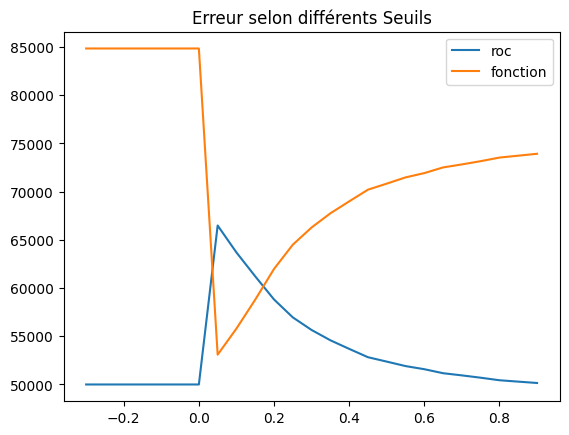

In [126]:
plt.plot(tab_seuil_auc['Seuil'], tab_seuil_auc['erreur'], label="roc")
plt.plot(tab_seuil['Seuil'],tab_seuil['erreur'],label="fonction")
plt.title('Erreur selon différents Seuils')
plt.legend()
plt.show()

# Evidently 

Pour etre au plus proche des variables de l'entrainement on utilise la meme structure de pipeline.

In [9]:
with open('pipeline_transfo_model.pkl','rb') as pi_mo:
    pi_mo = pickle.load(pi_mo) 

In [11]:
pi_mo['modelisation']

Pipeline(steps=[('clf',
                 LGBMClassifier(learning_rate=0.4, n_estimators=500,
                                random_state=42))])

In [13]:
new_data = pi_mo['categ_scaler'].transform(df_train.drop('TARGET', axis=1))

In [20]:
new_data = pd.DataFrame(data=new_data,
             columns = [re.sub('one-hot-encoder__|remainder__', '', col_names) for col_names in pi_mo['categ_scaler'].get_feature_names_out()])


In [21]:
new_data = pd.concat([new_data, df_train['TARGET']], axis=1)

In [27]:
new_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x),inplace=True) # pour éviter LightGBMError: Do not support special JSON characters in feature name.

In [35]:
data_ref = new_data.sample(n=1000, replace=False) #300
data_cur = new_data.sample(n=900, replace=False) #200

data_label_ref = data_ref.copy(deep=True)
data_label_cur = data_cur.copy(deep=True)

model = lgb.LGBMClassifier(learning_rate=0.4, n_estimators=500, random_state=42)

model.fit(data_ref.drop(['TARGET'], axis=1), data_ref.TARGET)

data_ref['prediction'] = model.predict_proba(data_ref.drop(['TARGET'],axis=1))[:,1]
data_cur['prediction'] = model.predict_proba(data_cur.drop(['TARGET'],axis=1))[:,1]


data_label_ref['prediction'] = model.predict(data_label_ref.drop(['TARGET'],axis=1))
data_label_cur['prediction'] = model.predict(data_label_cur.drop(['TARGET'],axis=1))

In [36]:
data_drift_report = Report(metrics=[
    DataDriftPreset(num_stattest='ks', cat_stattest='psi', num_stattest_threshold=0.2, cat_stattest_threshold=0.2),
])

data_drift_report.run(reference_data=data_ref, current_data=data_cur)
data_drift_report

Export rapport de drift 

In [37]:
data_drift_report.save_html('data_drift_report_smaller.html') #v2 echantillon egal à 1/3 du dataset

#modif alphas modification ajout 30,70,100
#Leave-One-Out cross-validation chaque observation est testé si cv = none mais recquiert beaucoup de temps, meilleur cv = 10 
#ColumnTransformer rajouté sinon onehot fait pour toutes les colonnes
pipel= Pipeline(steps=[('categ_scaler', ColumnTransformer([('one-hot-encoder', OneHotEncoder(handle_unknown="ignore", categories = ar_val), ar.values)],remainder=StandardScaler(with_mean=True), verbose = True)),
                       ('rfe',   RFE(estimator = RidgeClassifierCV(class_weight='balanced',cv=3,alphas=(500,600),scoring = 'recall'),
                                 step=10,
                                 verbose = 5
                                    )
                       )
                    ])
#('model',RidgeClassifierCV(class_weight='balanced', alphas=(0.1,1,10,100,1000))) cv = 3 sinon 10 trop long

In [ ]:
#!pip install lifelines https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html?highlight=cox

# SHAP

In [14]:
# Fits the explainer
explainer = shap.Explainer(pi_mo['modelisation'].predict, X_train_over)

Export shap explainer

with  open("true_explainer.pkl", "wb") as t_p :
    pickle.dump(explainer, t_p)

In [40]:
# Fits the explainer
#explainer = shap.Explainer(search.best_estimator_.predict, X_train_over)
# Calculates the SHAP values only on one tenth of the data takes a lot of time
X_test_1_10 = round(X_test.shape[0]/10) #1/10 des données de X_test
shap_values = explainer(pi_mo["categ_scaler"].transform(X_test.sample(X_test_1_10, random_state=42) ))

NameError: name 'explainer' is not defined

In [38]:
df_shap_imp = pd.read_csv("shap_glob_val_sup_0.csv")

In [50]:
y


array([4.  , 2.25, 1.  , 0.25, 0.  , 0.25, 1.  , 2.25, 4.  ])

In [109]:
val_transfo = model_0["categ_scaler"].transform(pd.DataFrame(X_test.loc[0,:]).transpose())
val_transfo = pd.DataFrame(data=val_transfo,
                           columns= [re.sub('one-hot-encoder__|remainder__', '', col_names)
            for col_names in model_0["categ_scaler"].get_feature_names_out()])


In [82]:
explainer(val_transfo.values)

.values =
array([[ 0.   ,  0.   , -0.015,  0.145,  0.   , -0.035,  0.03 , -0.155,
         0.03 , -0.015,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.03 ,  0.005,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.005, -0.005,  0.   ,  0.   ,  0.   , -0.01 , -0.01 , -0.005,
        -0.005,  0.005,  0.   , -0.025,  0.   ,  0.   ,  0.   , -0.005,
         0.   , -0.015,  0.   ,  0.   ,  0.   ,  0.   , -0.005, -0.005,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   , -0.01 , -0.04 , -0.02 , -0.005, -0.005,
        -0.005,  0.   , -0.035,  0.   , -0.005,  0.   ,  0.   , -0.005,
         0.   ,  0.   ,  0.   ,  0.   , -0.005,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.005,
         0.   ,  0.   , -0.005,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   

Export pour test api

In [118]:
val_transfo_1 = pd.DataFrame(X_test.iloc[1, :]).transpose()
val_transfo_1.to_csv('X_3_test.csv', index = False)

In [53]:
shap_values.values


array([[ 0.   ,  0.   , -0.095, ..., -0.01 , -0.015, -0.03 ],
       [ 0.   ,  0.   ,  0.005, ..., -0.035, -0.015, -0.025],
       [ 0.   ,  0.   ,  0.03 , ..., -0.015, -0.015, -0.005],
       ...,
       [ 0.   ,  0.   ,  0.065, ...,  0.   , -0.025, -0.06 ],
       [ 0.   ,  0.   ,  0.055, ...,  0.   , -0.01 , -0.01 ],
       [-0.005,  0.005,  0.005, ..., -0.02 ,  0.   , -0.04 ]])

Visualisation des valeurs de shap

In [32]:
# moyenne des features importance chaque variable
mean_ = np.abs(shap_values.values).mean(axis=0)
# filtre des variables triées par ordre croissant et différents de 0
val_sorted = mean_[np.where(np.sort(mean_)!= 0, True, False)]
# filtre des index des variables triées par ordre croissant et différents de 0
idx_val_sorted = np.argsort(mean_)[np.where(np.sort(mean_) != 0, True, False)]

len(mean_),len(val_sorted)

(245, 226)

In [28]:
# feature importance globale shap_value pour plusieurs prédictions a faire avec x Test
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, CDSView, BooleanFilter
from bokeh.plotting import figure

TOOLTIPS = [
    ("index", "$index"),
    ("Importance de la variable", "@x"),  # v3
    ("Nom de la variable", "@y")]
colonnes = [re.sub('one-hot-encoder__|remainder__', '', col_names)
            for col_names in pipeline_o['categ_scaler'].get_feature_names_out()]

data = dict(x=val_sorted,
            y=[colonnes[index_col] for index_col in idx_val_sorted])  # a changer avec toutes les colonnes

source = ColumnDataSource(data)
p = figure(y_range=source.data['y'],
           x_range=((min(source.data['x'])-0.005),
                    (max(source.data['x'])+0.05)),
           width=600, height=750, toolbar_location=None,
           title="Importance des variables pour les prédictions",
           tooltips=TOOLTIPS)

p.hbar(y='y', right="x", left=0, height=0.4, source=source)

p.ygrid.grid_line_color = None
p.xaxis.axis_label = "feature_importance par variable"
p.yaxis.major_label_text_font_size = "6pt"
p.outline_line_color = None
show(p)

Export shap_values_globale

In [45]:
shap_glob_val = pd.DataFrame(list(zip(colonnes,mean_)),
                             columns=['nom_variables','feature_importance'])
shap_glob_val.shape

(245, 2)

In [47]:
shap_glob_val_sup_0 = shap_glob_val[abs(shap_glob_val['feature_importance'])>0.00001].copy()
shap_glob_val_sup_0.sort_values(ascending=False, inplace =True, by='feature_importance')
shap_glob_val_sup_0.head(),shap_glob_val_sup_0.shape

(                  nom_variables  feature_importance
 244  AMT_REQ_CREDIT_BUREAU_YEAR            0.040609
 3                 CODE_GENDER_M            0.040377
 5                FLAG_OWN_CAR_N            0.040023
 161     HOUR_APPR_PROCESS_START            0.037446
 170                EXT_SOURCE_3            0.034710,
 (213, 2))

Export

In [48]:
shap_glob_val_sup_0.to_csv('shap_glob_val_sup_0.csv',index=False)

In [ ]:
# enable output to display directly in the notebook
output_notebook()

In [ ]:
file =  {'file': open('echantillon_test.csv', 'rb')}
#file_json = pd.read_csv('echantillon_test.csv')

In [ ]:

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
counts = [5, 3, 4, 2, 4, 6]

p = figure(x_range=b, height=250, title="Fruit counts",
           toolbar_location=None, tools="")

p.vbar(x=b, top=a, width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)


In [466]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Select

# define the data for the scatter plot
x_data = [1, 2, 3, 4, 5]
y_data = [6, 7, 2, 4, 5]
scatter_source = ColumnDataSource(data={'x': x_data, 'y': y_data})

# create a Bokeh figure for the scatter plot
scatter_fig = figure(width=400, height=400)
scatter_fig.circle(x='x', y='y', source=scatter_source, size=12)

# define the data for the line chart
line_x_data = [1, 2, 3, 4, 5]
line_y_data = [6, 7, 2, 4, 5]
line_source = ColumnDataSource(data={'x': line_x_data, 'y': line_y_data})

# create a Bokeh figure for the line chart
line_fig = figure(width=400, height=400)
line_fig.line(x='x', y='y', source=line_source, line_width=2)

# create a Select widget for choosing the chart type
chart_type_select = Select(
    options=['Scatter', 'Line'], value='Scatter', title='Chart Type')

# define the callback function to change the chart type based on the Select widget value


def update_chart_type(attr, old, new):
    if new == 'Scatter':
        layout.children[1] = scatter_fig
    else:
        layout.children[1] = line_fig


# attach the callback function to the Select widget
chart_type_select.on_change('value', update_chart_type)

# create a layout for the Select widget and initial chart
layout = column(chart_type_select, scatter_fig)

# display the layout in the notebook
show(layout)


You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [ ]:
test_echan.groupby(['NAME_INCOME_TYPE']).mean(numeric_only=True)['AMT_ANNUITY']


In [473]:
from bokeh.models import Div

# create a plot
p = figure()
p.circle([1, 2, 3], [4, 5, 6])

# create an empty Div widget
spacer = Div(text="")

# create a layout column with the plot and the spacer
layout = column(p, spacer)

show(layout)

Test et envoi de fichier a fastapi

In [ ]:
file_path = 'echantillon_test.csv'
url = 'http://127.0.0.1:8000/uploadfile/'
with open(file_path, "rb") as file:
    response = requests.post(url, files={"file": file})

#print(response.status_code)
print(response.content)
response.json()['contents']
pd.DataFrame(columns=response.json()[
             'contents'][0], data=response.json()['contents'][1:])


In [ ]:
len(file['file'].read())